<a href="https://colab.research.google.com/github/BlancaAlfaro/Projet8/blob/main/Test_anomalib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastFlow P.O.C.

The aim of this notebook is to provide a proof-of-concept for the FastFlow method [(https://arxiv.org/abs/2111.07677)](https://arxiv.org/abs/2111.07677)

FastFlow will be tested on an anomaly detection task on images from the BTAD dataset.

### Imports

In [48]:
work_folder='/content/drive/MyDrive/OC - Projets/Projet 8/'

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%pip install anomalib[full]

In [51]:
!pip install --upgrade certifi

In [52]:
!pip install pyod

In [53]:
 !pip install shap

In [54]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import seaborn as sns
import shap
from anomalib import TaskType
from anomalib.data import BTech, Folder
from anomalib.engine import Engine
from anomalib.models import Fastflow
from anomalib.utils.post_processing import superimpose_anomaly_map
from PIL import Image
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,f1_score,recall_score,roc_auc_score
from torchvision.transforms import ToPILImage
from torchsummary import summary
from torchvision import models


In [55]:
%matplotlib inline

### Data loading

In [56]:
# Load datamodule
datamodule = BTech(num_workers=2,root=work_folder+'/BTech/',eval_batch_size=8)# Image size being quite significant, batch size is reduced to 8 for feature extraction


In [57]:
datamodule.prepare_data()

In [58]:
datamodule.setup()

In [59]:
print("Size of training set: " +str(len(datamodule.train_data))+ " - split into " + str(len(datamodule.train_dataloader()))+ " batches")
print("Size of validation set: " + str(len(datamodule.val_data)) + " - split into " + str(len(datamodule.val_dataloader()))+ " batches")
print("Size of test set: " + str(len(datamodule.test_data)) + " - split into " + str(len(datamodule.test_dataloader()))+ " batches")

Size of training set: 400 - split into 13 batches
Size of validation set: 70 - split into 9 batches
Size of test set: 70 - split into 9 batches


In [60]:
#Check train batch content
i,X_train_1=next(enumerate(datamodule.train_dataloader()))
print(X_train_1.keys())
print("Size of first batch: ",len(X_train_1['label']))
print(X_train_1['image'].shape)

dict_keys(['image_path', 'label', 'image', 'mask'])
Size of first batch:  32
torch.Size([32, 3, 1600, 1600])


In [61]:
#Check test batch content
i,X_test_1=next(enumerate(datamodule.test_dataloader()))
print(X_test_1.keys())
print("Size of first batch: ",len(X_test_1['label']))
print(X_test_1['image'].shape)

dict_keys(['image_path', 'label', 'image', 'mask'])
Size of first batch:  8
torch.Size([8, 3, 1600, 1600])


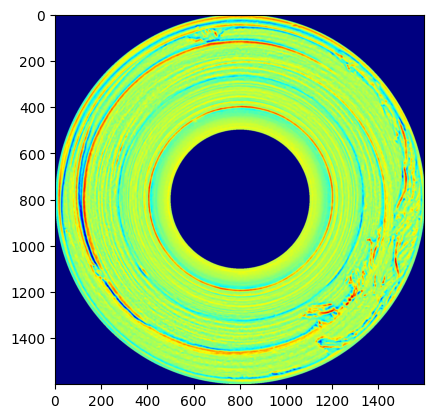

In [98]:
# Show an image from the test batch
i=5
image = Image.open(X_test_1["image_path"][i])
plt.imshow(image)
plt.show()

## Modelisation

### Baseline

FastFlow will be compared with a baseline consisting of a features extraction with ResNet18 (the same extractor used by FastFlow) and an anomaly detection algorithm : Iforest and Knn.

In [63]:
# Load feature extraction model
base_model = models.resnet18(pretrained=True)
for param in base_model.parameters():
        param.requires_grad = False
model = torch.nn.Sequential(*(list(base_model.children())[:-1]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model,(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [64]:
# Extract features
features_list=[]
true_labels=[]
image_paths=[]
for batch in datamodule.test_dataloader():
    true_labels.append(batch['label'].numpy())
    image_paths.append(batch['image_path'])
    images=batch['image'].to(device)
    features=model(images)
    features_list.append(pd.DataFrame(features.cpu().numpy().reshape(-1, 512)))
features=pd.concat(features_list,axis=0)
true_labels=np.concatenate(true_labels)
image_paths=np.concatenate(image_paths)

In [65]:
features

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.821015,1.019594,0.742210,1.389007,1.030926,0.956577,1.180750,0.881469,0.713405,0.908307,...,0.832668,0.643594,0.619915,0.676507,1.133269,0.948196,0.780435,0.913473,0.846365,0.847561
1,1.015274,0.973651,0.779575,1.353745,0.908108,0.907623,1.099769,1.196109,1.057978,1.131060,...,0.931040,0.734466,0.771486,0.769571,1.161456,0.872094,0.881935,0.907991,0.865261,0.694469
2,0.868548,0.949363,0.949253,0.796829,0.923856,0.787463,0.943242,1.484530,1.144031,0.764452,...,0.665382,0.741246,0.756475,0.810735,1.028901,1.027404,0.744143,0.871138,1.390284,0.878855
3,0.701580,0.925195,1.057331,0.671964,0.792121,0.702072,0.708601,1.027698,1.109640,0.796135,...,1.236226,1.102850,1.060844,1.049986,1.025136,0.980699,0.863889,0.735801,1.131068,0.566776
4,0.889076,0.861942,0.989429,0.824797,0.798617,0.974147,0.878724,1.206785,0.954514,0.814176,...,0.954438,0.925893,0.950148,0.814451,0.893457,0.855423,0.834316,0.861352,1.101663,1.017739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.816553,0.999718,1.048079,0.861715,0.846006,0.964096,0.849769,1.116437,1.116989,0.920054,...,0.836886,1.270867,0.971308,0.985985,1.263272,0.991515,0.931440,1.251617,0.984600,0.812577
2,0.874477,0.919049,0.840816,0.992833,0.931590,0.655236,1.106288,1.104328,0.760625,0.925054,...,0.995700,0.747698,0.552622,0.928508,0.942816,0.973103,0.740366,0.706649,1.163541,0.586051
3,0.845942,0.905831,0.873038,0.838772,0.803368,0.996352,1.028587,1.166321,1.091115,0.917000,...,0.904993,0.868501,0.864198,0.612804,1.063337,0.881012,0.769639,0.934830,0.886389,1.080456
4,0.852643,0.840155,0.915171,1.075389,0.883901,0.841129,0.821280,0.988888,0.766314,0.744932,...,1.099279,0.737903,0.953929,0.928684,1.279049,0.752686,0.883295,0.661974,1.003862,0.865586


#### with IForest

In [66]:
# Fit anomaly detection model on features
iforest=IForest(contamination=0.05,random_state=42)
iforest.fit(features)

IForest(behaviour='old', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=42, verbose=0)

In [67]:
# Get predictions
iforest_pred=iforest.predict(features)
# Get scores
iforest_scores=iforest.decision_scores_


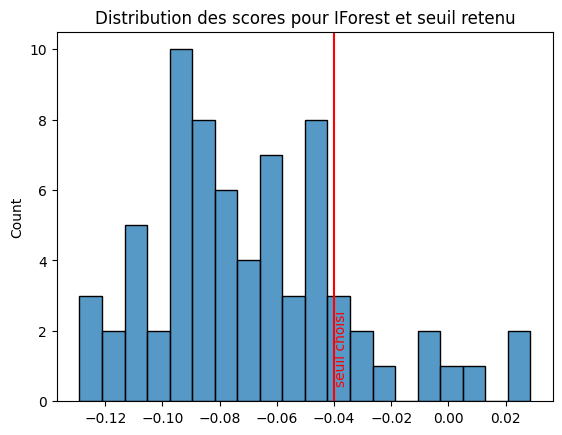

In [68]:
# Threshold selection
iforest_threshold = -0.04
sns.histplot(iforest_scores,bins=20)
plt.axvline(iforest_threshold,color='red')
plt.annotate('seuil choisi',xy=(iforest_threshold,0.5),color='red',rotation=90)
plt.title('Distribution des scores pour IForest et seuil retenu')
plt.show()

In [69]:
iforest_pred_custom=iforest_scores>iforest_threshold

In [70]:
def plot_metrics(true_labels,pred_labels,model_name):
  """Plot metrics on model performance

  Parameters
  ----------
  true_labels : np.array
      real labels for the data
  pred_labels : np.array
      predicted labels for the data
  model_name : str
      name of the model to use for plot titles
  Returns
  -------
  tuple
      f1_score, recall, auroc metrics computed on the data
  """
  cm=confusion_matrix(true_labels,pred_labels)
  ConfusionMatrixDisplay(cm).plot()
  title='Confusion matrix with '+model_name
  plt.title(title)
  plt.show()

  print("Metrics with "+model_name)
  f1= f1_score(true_labels,pred_labels)
  recall= recall_score(true_labels,pred_labels)
  auroc= roc_auc_score(true_labels,pred_labels)
  print('F1_score',f1.round(2))
  print('Recall',recall.round(2))
  print('AUROC',auroc.round(2))

  return f1,recall,auroc

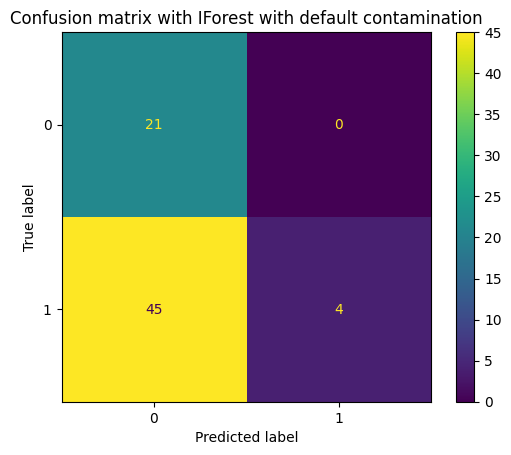

Metrics with IForest with default contamination
F1_score 0.15
Recall 0.08
AUROC 0.54
------------------------------------------------------


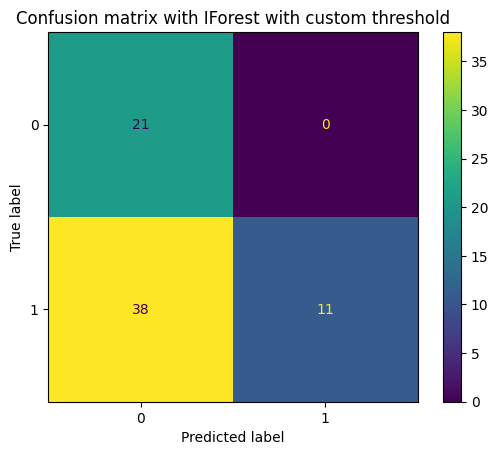

Metrics with IForest with custom threshold
F1_score 0.37
Recall 0.22
AUROC 0.61


In [71]:
f1_iforest_default,recall_iforest_default,auroc_iforest_default=plot_metrics(true_labels,iforest_pred,'IForest with default contamination')
print("------------------------------------------------------")
f1_iforest_custom,recall_iforest_custom,auroc_iforest_custom=plot_metrics(true_labels,iforest_pred_custom,'IForest with custom threshold')

#### with Knn

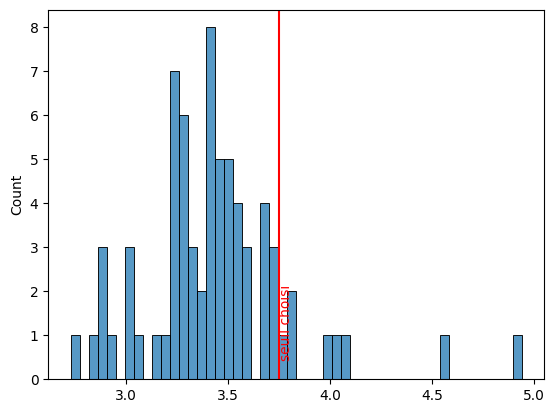

In [72]:
# Fit anomaly detection model on features
knn=KNN()
knn.fit(features)
# Get predictions
knn_pred=knn.predict(features)
# Get scores
knn_scores=knn.decision_function(features)

# Threshold selection
knn_threshold = 3.75
sns.histplot(knn_scores,bins=50)
plt.axvline(knn_threshold,color='red')
plt.annotate('seuil choisi',xy=(knn_threshold,0.5),color='red',rotation=90)
plt.show()

In [73]:
knn_pred_custom=knn_scores>knn_threshold

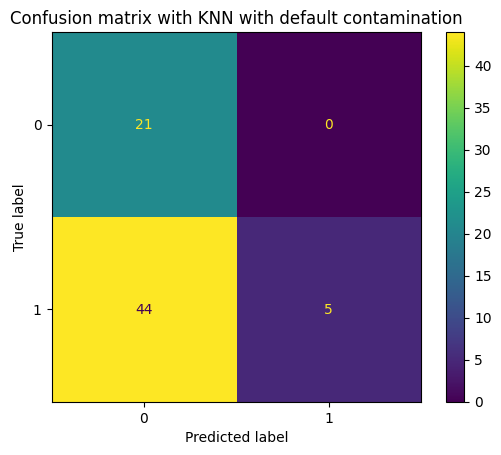

Metrics with KNN with default contamination
F1_score 0.19
Recall 0.1
AUROC 0.55
------------------------------------------------------


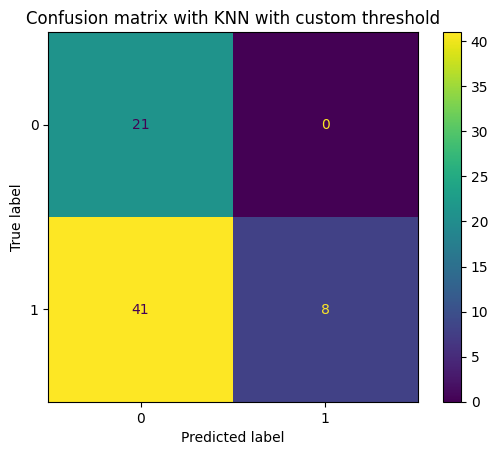

Metrics with KNN with custom threshold
F1_score 0.28
Recall 0.16
AUROC 0.58


In [74]:
f1_knn_default,recall_knn_default,auroc_knn_default=plot_metrics(true_labels,knn_pred,'KNN with default contamination')
print("------------------------------------------------------")
f1_knn_custom,recall_knn_custom,auroc_knn_custom=plot_metrics(true_labels,knn_pred_custom,'KNN with custom threshold')

### FastFlow

For FastFlow, the implementation available at the anomalib library will be used.

In [75]:
model=Fastflow()
engine = Engine(task=TaskType.DETECTION,max_epochs=1)
engine.fit(model=model, datamodule=datamodule)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss                  │ FastflowLoss             │      0 │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MinMax                   │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 7 │ model                 │ FastflowModel            │  7.7 M │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 3.5 M                                                                                            
Non-trainable params: 4.2 M                                                                                        
Total params: 7.7 M                                                                                                
Total estimated model params size (MB): 30                                                                         
Modules in train mode: 258                                                                                         
Modules in eval mode: 0

Output()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/module.py:516: You called `self.log('train_loss', 
..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [76]:
engine.test(
    datamodule=datamodule,
    model=model)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9679300785064697     │
│       image_F1Score       │    0.9473684430122375     │
└───────────────────────────┴───────────────────────────┘

[{'image_AUROC': 0.9679300785064697, 'image_F1Score': 0.9473684430122375}]

In [77]:
predictions = engine.predict(
    datamodule=datamodule,
    model=model,
    ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
)

INFO: Restoring states from the checkpoint path at /content/results/Fastflow/BTech/01/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/Fastflow/BTech/01/v1/weights/lightning/model.ckpt
INFO: Loaded model weights from the checkpoint at /content/results/Fastflow/BTech/01/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/Fastflow/BTech/01/v1/weights/lightning/model.ckpt


Output()

In [78]:
real_labels=np.array([])
predicted_labels=np.array([])
image_paths=[]
for batch in range(len(predictions)) :
    real_labels=np.append(real_labels,predictions[batch]['label'].numpy())
    predicted_labels=np.append(predicted_labels,predictions[batch]['pred_labels'].numpy())
    image_paths=image_paths+predictions[batch]['image_path']


In [79]:
results=pd.DataFrame({'image_paths':image_paths,'real_labels': real_labels,'predicted_labels':predicted_labels})
results

,image_paths,real_labels,predicted_labels
0,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,1.0
1,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,1.0
2,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,1.0
3,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,0.0
4,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,1.0
...,...,...,...
65,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.0,0.0
66,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.0,0.0
67,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.0,0.0
68,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.0,0.0


In [80]:
f1_fastflow,recall_fastflow,auroc_fastflow=plot_metrics(results['real_labels'],results['predicted_labels'],'FastFlow')

Metrics with FastFlow
F1_score 0.96
Recall 0.94
AUROC 0.95


In [81]:
miss_predicted=results[results['real_labels']!=results['predicted_labels']]
miss_predicted

,image_paths,real_labels,predicted_labels
3,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,0.0
11,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,0.0
30,/content/drive/MyDrive/OC - Projets/Projet 8/B...,1.0,0.0
69,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.0,1.0


In [82]:
mask_folder=work_folder+"BTech/01/ground_truth/ko/"
for label, path in zip(miss_predicted['real_labels'],miss_predicted['image_paths']) :
    print(path)
    filename=os.path.basename(path.replace('.bmp','.png'))
    image = Image.open(path)
    plt.imshow(image)
    plt.show()
    if label == 1:
        mask=Image.open(mask_folder+filename)
        plt.imshow(mask)
        plt.show()

/content/drive/MyDrive/OC - Projets/Projet 8/BTech/01/test/ko/0003.bmp
/content/drive/MyDrive/OC - Projets/Projet 8/BTech/01/test/ko/0011.bmp
/content/drive/MyDrive/OC - Projets/Projet 8/BTech/01/test/ko/0031.bmp
/content/drive/MyDrive/OC - Projets/Projet 8/BTech/01/test/ok/0020.bmp


## Results recap

In [83]:
pd.DataFrame([[f1_iforest_default,f1_iforest_custom,f1_knn_default,f1_knn_custom,f1_fastflow],
              [recall_iforest_default,recall_iforest_custom,recall_knn_default,recall_knn_custom,recall_fastflow],
              [auroc_iforest_default,auroc_iforest_custom,auroc_knn_default,auroc_knn_custom,auroc_fastflow],
              ],
             columns=['IForest_default','IForest_custom','KNN_default','KNN_custom','FastFlow'],
             index=['F1_score','Recall','AUROC']
).round(2)

,IForest_default,IForest_custom,KNN_default,KNN_custom,FastFlow
F1_score,0.15,0.37,0.19,0.28,0.96
Recall,0.08,0.22,0.10,0.16,0.94
AUROC,0.54,0.61,0.55,0.58,0.95


#####  Importance of contamination

An issue with classical approaches is that contamination needs to be set. In order to estimate how not setting the right contamination affects performance, compared to other potential issues (ex : the right features not being learnt), prediction will be made with IForest with the right amount of customization.

In [84]:
print("True contamination : ",true_labels.sum()/len(true_labels))
print("Estimated contamination : ", np.round(iforest_pred.sum()/len(iforest_pred),2))

True contamination :  0.7
Estimated contamination :  0.06


We can see the true contamination is far above the estimated one.

In [85]:
# Select 70% most anomalous
true_contamination=0.7
sorted_scores=pd.DataFrame({'image_path':image_paths,'score':iforest_scores,'true_labels':true_labels}).sort_values('score',ascending=False)
sorted_scores['predicted_label']=0
sorted_scores.iloc[:int(true_contamination*len(sorted_scores))].loc[:,'predicted_label']=1
sorted_scores

,image_path,score,true_labels,predicted_label
24,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.028650,1,1
27,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.021515,1,1
15,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.005502,1,1
31,/content/drive/MyDrive/OC - Projets/Projet 8/B...,0.002486,1,1
16,/content/drive/MyDrive/OC - Projets/Projet 8/B...,-0.003039,1,1
...,...,...,...,...
60,/content/drive/MyDrive/OC - Projets/Projet 8/B...,-0.116055,0,0
5,/content/drive/MyDrive/OC - Projets/Projet 8/B...,-0.117462,1,0
63,/content/drive/MyDrive/OC - Projets/Projet 8/B...,-0.121696,0,0
52,/content/drive/MyDrive/OC - Projets/Projet 8/B...,-0.124509,0,0


In [86]:
#Check proportions
sorted_scores['predicted_label'].value_counts(normalize=True)

,proportion
predicted_label,
1,0.7
0,0.3


In [87]:
_=plot_metrics(sorted_scores['true_labels'],sorted_scores['predicted_label'],model_name='Fake iforest with known contamination')

Metrics with Fake iforest with known contamination
F1_score 0.86
Recall 0.86
AUROC 0.76


Without getting close to FastFlow performance, the increase in all scores show how highly low performance of classic anomaly detection algorithms is related to not having the information on the true contamination of this dataset.

## Feature importance

In [99]:
def plot_anomaly_map(batch_index,image_index,figsize=(15,10)):
  """Plot anomaly map for a given image
  Parameters
  ----------
  batch_index : int
      index of the batch
  image_index : int
      index of the image in the batch
  figsize : tuple, optional
      size of the figure, by default (15,10)

  Returns
  -------
  fig
      figure with the anomaly map
  """


  fig,axs=plt.subplots(1,3,figsize=figsize)
  #Load and plot image
  image_path=predictions[batch_index]['image_path'][image_index]
  image_size=predictions[batch_index]['image'][image_index].shape[-2:]
  image = np.array(Image.open(image_path).resize(image_size))
  axs[0].imshow(image)
  axs[0].set_title('Product image')
  #Load and plot anomaly map
  anomaly_map = predictions[batch_index]["anomaly_maps"][image_index]
  anomaly_map = anomaly_map.cpu().numpy().squeeze()
  axs[1].imshow(anomaly_map)
  axs[1].set_title('Anomaly map')
  # Plot superposition
  heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
  axs[2].imshow(heat_map)
  axs[2].set_title('Superposition of image and anomaly map')
  plt.tight_layout()
  return fig

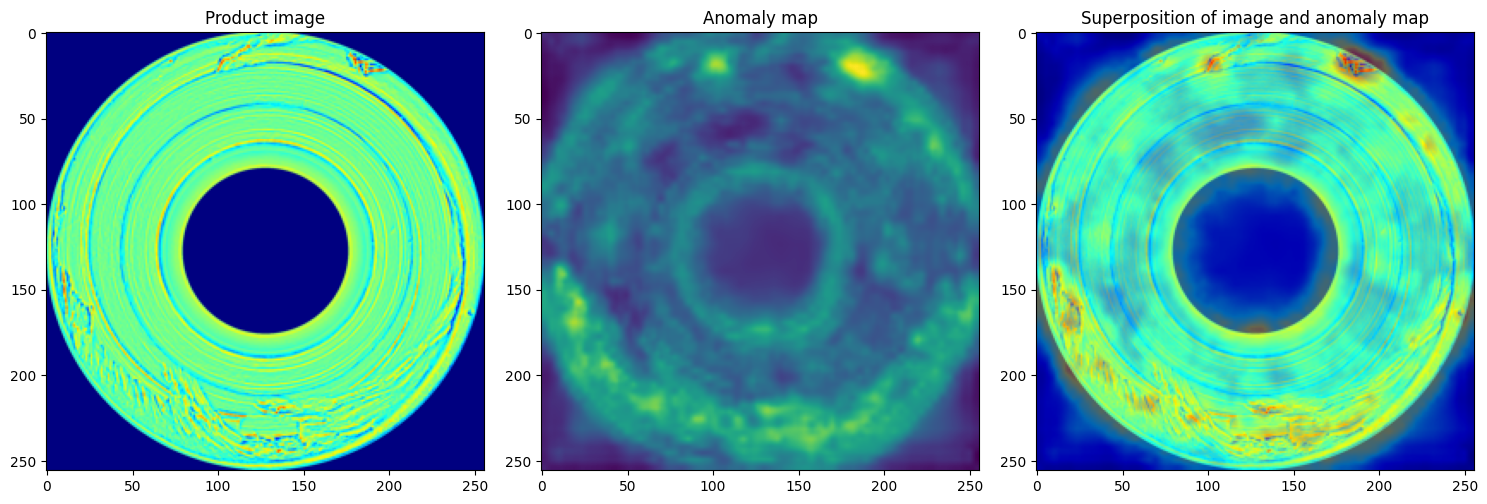

In [100]:
fig=plot_anomaly_map(batch_index=0,image_index=0)
plt.show()

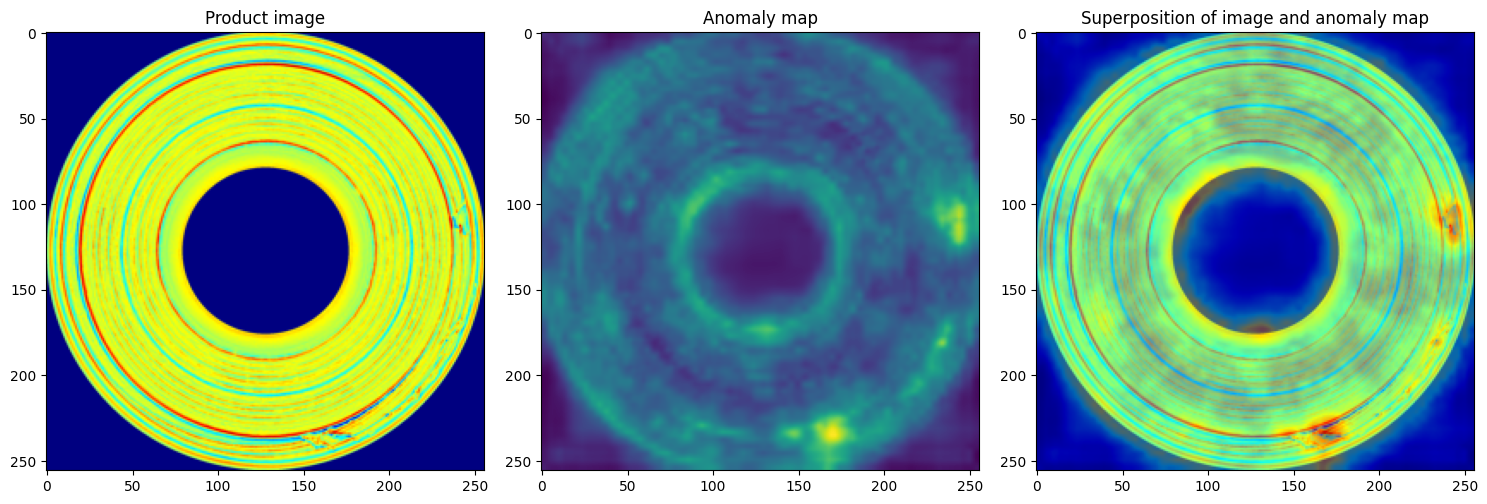

In [101]:
fig=plot_anomaly_map(batch_index=5,image_index=3)
plt.show()

In [91]:
anomaly_maps=[]
for batch_index in range(0,len(predictions)):
  for image_index in range(0,len(predictions[batch_index]["anomaly_maps"])):
    anomaly_map = predictions[batch_index]["anomaly_maps"][image_index]
    anomaly_map = anomaly_map.cpu().numpy().squeeze()
    anomaly_maps.append(anomaly_map)

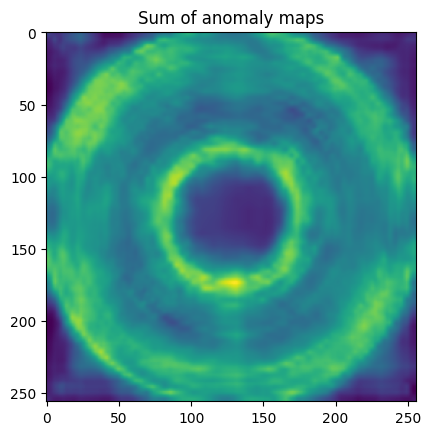

In [102]:
plt.imshow(sum(anomaly_maps))
plt.title('Sum of anomaly maps')
plt.show()

In [93]:
masks=[]
for batch_index in range(0,len(predictions)):
  for image_index in range(len(predictions[batch_index]["mask"])):
    masks.append(predictions[batch_index]['mask'][image_index])

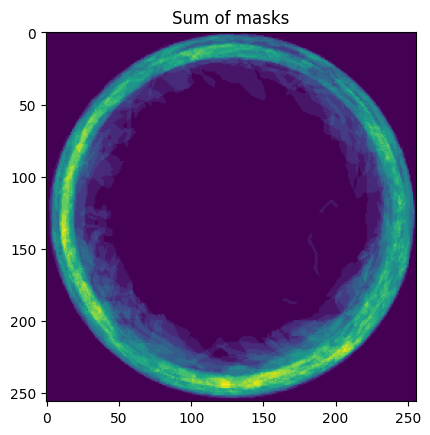

In [103]:
plt.imshow(sum(masks))
plt.title('Sum of masks')
plt.show()